In [ ]:
#importation des bibliothéques
from pyspectra.readers.read_spc import read_spc_dir, read_spc
from matplotlib import pyplot as plt
import pandas as pd 
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import linregress

In [ ]:
#Récupération des données d'entraînement sous forme d'un DataFrame 
from data_wrapper import *

df1=data_wrapper_j1()
df2=data_wrapper_j2()
df3=data_wrapper_j3()

df12=pd.concat([df1,df2],axis=0)
df123=pd.concat([df12,df3])

df=df123
df.head()


In [4]:

def integrale(dataframe,borne_début,borne_fin):
    """#fonction qui calcule l'aire sous un pic déterminé"""
    borne_début=int(borne_début)
    borne_fin=int(borne_fin)
    col_supp=dataframe.columns[:7]  # on sélectionne les colonnes à supprimer qui ne correspondent pas au spectre
    df_data=dataframe.drop(columns=col_supp)
    df_tranche=df_data.iloc[:, [i-200 for i in range(int(borne_début),int(borne_fin))]]
    #on va supprimer le trapèze en dessous du spectre
    df_x=df_data.iloc[:,borne_début-200]
    df_y=df_data.iloc[:,borne_fin-200]
    aire_trapeze=(borne_fin-borne_début)*(df_x+df_y)/2
    return df_tranche.sum(axis=1)-aire_trapeze

## Recherche de la meilleur fenetre pour le glucose 

In [ ]:
# Initialisation des meilleures valeurs globales
best_mse_global = float('inf')
best_window_global = (0, 0)
best_lm_glucose_global = None
best_x_glucose_global = None
best_y_glucose_global = None
best_y_pred_global = None
best_residus_glucose_global = None
best_pic_global = None

In [10]:
from sklearn.linear_model import LinearRegression

In [ ]:

# Liste des pics à tester
pics = [406, 531, 468]
mse_results_by_pic = {}  # Pour stocker les résultats de chaque pic

for pic in pics:
    best_mse = float('inf')
    best_window = (0, 0)
    best_lm_glucose = None
    best_x_glucose = None
    best_y_glucose = None
    best_y_pred = None
    best_residus_glucose = None

    # Boucle pour tester différentes tailles de fenêtres
    window_sizes = range(10, 200, 10)
    center = pic

    mse_results_by_pic[pic] = {'window_sizes': [], 'mses': [], 'best_size': None, 'best_mse': None}

    for size in window_sizes:
        imin = center - size // 2
        imax = center + size // 2

        # Calcul de l'aire sous la courbe pour la fenêtre actuelle
        df_train=integrale(df,imin,imax)

        X_train=df_train[df_train.keys()[:]].tolist()
        Y_train=df['Glucose'].tolist()

        model=LinearRegression()
        model.fit(X_train,Y_train)

        y_pred = model.predict(X_train)
        #calcul de la Mean Square Error
        MSE=mean_squared_error(Y_train,y_pred)

        # Sauvegarde des résultats
        mse_results_by_pic[pic]['window_sizes'].append(size)
        mse_results_by_pic[pic]['mses'].append(MSE)

        if MSE < best_mse:
            best_mse = MSE
            best_window = (imin, imax)
            best_lm_glucose = model
            best_x_glucose = X_train
            best_y_glucose = Y_train
            best_y_pred = y_pred
            best_residus_glucose = Y_train - y_pred
            mse_results_by_pic[pic]['best_size'] = size
            mse_results_by_pic[pic]['best_mse'] = MSE

    # Mettre à jour les meilleurs résultats globaux
    if best_mse < best_mse_global:
        best_mse_global = best_mse
        best_window_global = best_window
        best_lm_glucose_global = best_lm_glucose
        best_x_glucose_global = best_x_glucose
        best_y_glucose_global = best_y_glucose
        best_y_pred_global = best_y_pred
        best_residus_glucose_global = best_residus_glucose
        best_pic_global = pic

In [12]:
# Afficher les résultats pour la meilleure configuration globale
print(f"Meilleur pic global : {best_pic_global}")
print(f"Meilleure fenêtre : imin={best_window_global[0]}, imax={best_window_global[1]}")
print("Coefficient :", best_lm_glucose_global.coef_)
print("Intercept :", best_lm_glucose_global.intercept_)
print('MSE_glucose (global) =', best_mse_global)

Meilleur pic global : 468
Meilleure fenêtre : imin=378, imax=558
Coefficient : [0.00053985]
Intercept : -48.095587919530836
MSE_glucose (global) = 17.53674204623032


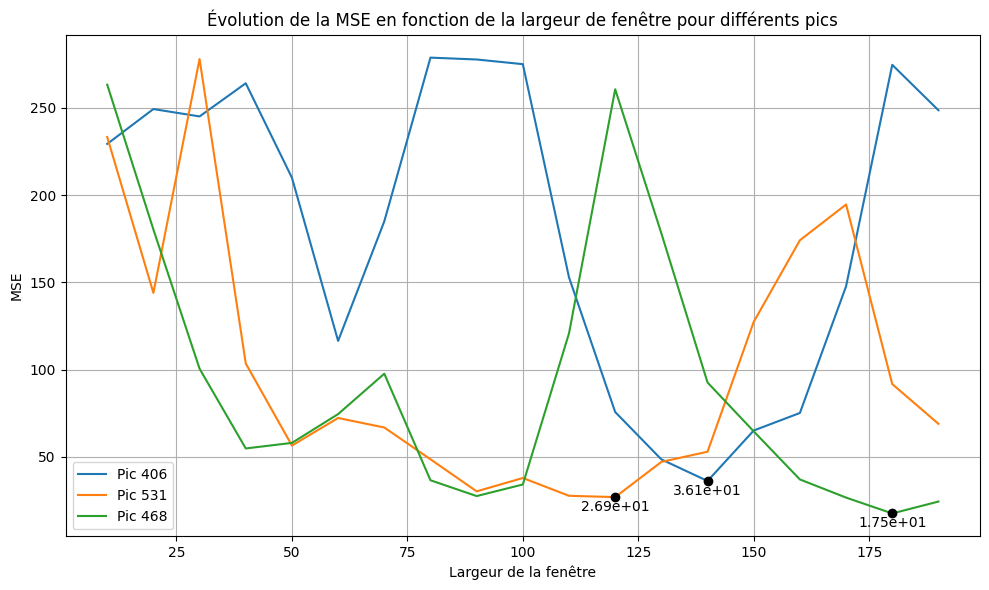

In [13]:
# Tracé de la MSE en fonction de la largeur de fenêtre
plt.figure(figsize=(10, 6))

for pic, data in mse_results_by_pic.items():
    plt.plot(data['window_sizes'], data['mses'], label=f"Pic {pic}")
    # Annotation du point minimal
    min_idx = np.argmin(data['mses'])
    min_size = data['window_sizes'][min_idx]
    min_mse = data['mses'][min_idx]
    plt.scatter(min_size, min_mse, color='black', zorder=5)
    plt.annotate(f"{min_mse:.2e}", (min_size, min_mse), textcoords="offset points", xytext=(0, -10), ha='center')

plt.xlabel("Largeur de la fenêtre")
plt.ylabel("MSE")
plt.title("Évolution de la MSE en fonction de la largeur de fenêtre pour différents pics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


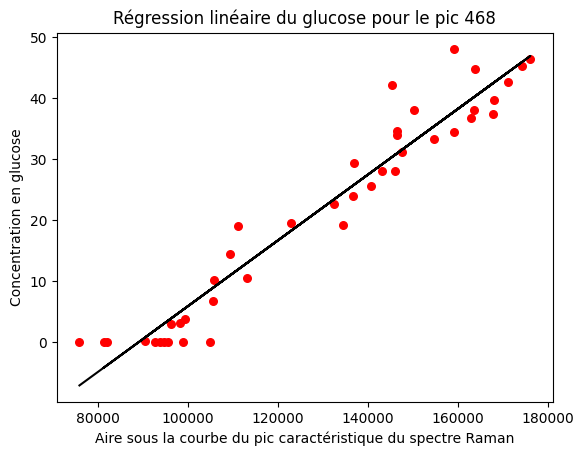

In [15]:

# Tracer la régression pour la meilleure configuration globale
plt.scatter(best_x_glucose_global, best_y_glucose_global, color="r", marker="o", s=30)
plt.plot(best_x_glucose_global, best_y_pred_global, color="k")
plt.xlabel("Aire sous la courbe du pic caractéristique du spectre Raman")
plt.ylabel("Concentration en glucose")
plt.title(f"Régression linéaire du glucose pour le pic {best_pic_global}")
plt.show()

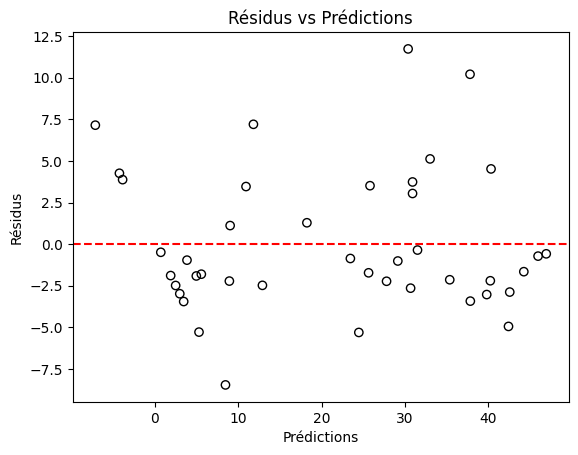

In [16]:
# Tracer les résidus pour la meilleure configuration globale
plt.scatter(best_y_pred_global, best_residus_glucose_global, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Résidus vs Prédictions')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.show()

## Recherche de la meilleur fenêtre pour l'éthanol

In [17]:
# Initialisation des meilleures valeurs globales
best_mse_global = float('inf')
best_window_global = (0, 0)
best_lm_ethanol_global = None
best_x_ethanol_global = None
best_y_ethanol_global = None
best_y_pred_global = None
best_residus_ethanol_global = None
best_pic_global = None


In [30]:

# Liste des pics à tester
pics = [875,1456]
mse_results_by_pic = {}  # Pour stocker les résultats de chaque pic

for pic in pics:
    best_mse = float('inf')
    best_window = (0, 0)
    best_lm_ethanol = None
    best_x_ethanol = None
    best_y_ethanol = None
    best_y_pred = None
    best_residus_ethanol = None

    # Boucle pour tester différentes tailles de fenêtres
    window_sizes = range(10, 200, 10)
    center = pic

    mse_results_by_pic[pic] = {'window_sizes': [], 'mses': [], 'best_size': None, 'best_mse': None}

    for size in window_sizes:
        imin = center - size // 2
        imax = center + size // 2

        # Calcul de l'aire sous la courbe pour la fenêtre actuelle
        df_train=integrale(df,imin,imax)

        X_train=df_train[df_train.keys()[:]].tolist()
        X_train=np.array(df_train).reshape(-1,1)
        Y_train=df['Ethanol'].tolist()

        model=LinearRegression()
        model.fit(X_train,Y_train)

        y_pred = model.predict(X_train)
        #calcul de la Mean Square Error
        MSE=mean_squared_error(Y_train,y_pred)

        # Sauvegarde des résultats
        mse_results_by_pic[pic]['window_sizes'].append(size)
        mse_results_by_pic[pic]['mses'].append(MSE)

        if MSE < best_mse:
            best_mse = MSE
            best_window = (imin, imax)
            best_lm_ethanol = model
            best_x_ethanol = X_train
            best_y_ethanol = Y_train
            best_y_pred = y_pred
            best_residus_ethanol = Y_train - y_pred
            mse_results_by_pic[pic]['best_size'] = size
            mse_results_by_pic[pic]['best_mse'] = MSE

    # Mettre à jour les meilleurs résultats globaux
    if best_mse < best_mse_global:
        best_mse_global = best_mse
        best_window_global = best_window
        best_lm_ethanol_global = best_lm_ethanol
        best_x_ethanol_global = best_x_ethanol
        best_y_ethanol_global = best_y_ethanol
        best_y_pred_global = best_y_pred
        best_residus_ethanol_global = best_residus_ethanol
        best_pic_global = pic

In [31]:
# Afficher les résultats pour la meilleure configuration globale
print(f"Meilleur pic global : {best_pic_global}")
print(f"Meilleure fenêtre : imin={best_window_global[0]}, imax={best_window_global[1]}")
print("Coefficient :", best_lm_ethanol_global.coef_)
print("Intercept :", best_lm_ethanol_global.intercept_)
print('MSE_Ethanol (global) =', best_mse_global)

Meilleur pic global : 875
Meilleure fenêtre : imin=855, imax=895
Coefficient : [0.00055578]
Intercept : 3.748697837836998
MSE_Ethanol (global) = 0.6874437719534549


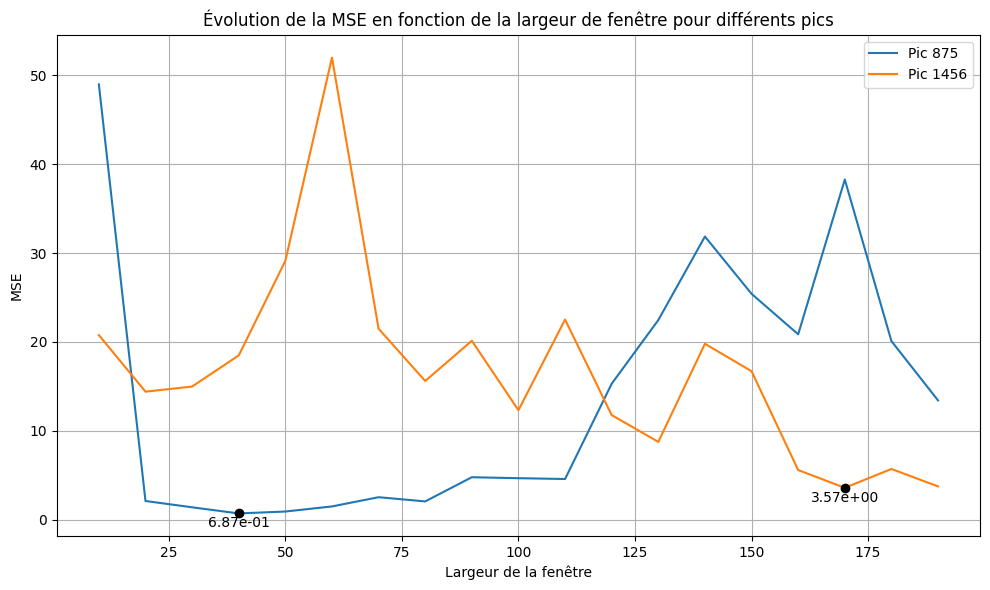

In [32]:
# Tracé de la MSE en fonction de la largeur de fenêtre
plt.figure(figsize=(10, 6))

for pic, data in mse_results_by_pic.items():
    plt.plot(data['window_sizes'], data['mses'], label=f"Pic {pic}")
    # Annotation du point minimal
    min_idx = np.argmin(data['mses'])
    min_size = data['window_sizes'][min_idx]
    min_mse = data['mses'][min_idx]
    plt.scatter(min_size, min_mse, color='black', zorder=5)
    plt.annotate(f"{min_mse:.2e}", (min_size, min_mse), textcoords="offset points", xytext=(0, -10), ha='center')

plt.xlabel("Largeur de la fenêtre")
plt.ylabel("MSE")
plt.title("Évolution de la MSE en fonction de la largeur de fenêtre pour différents pics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

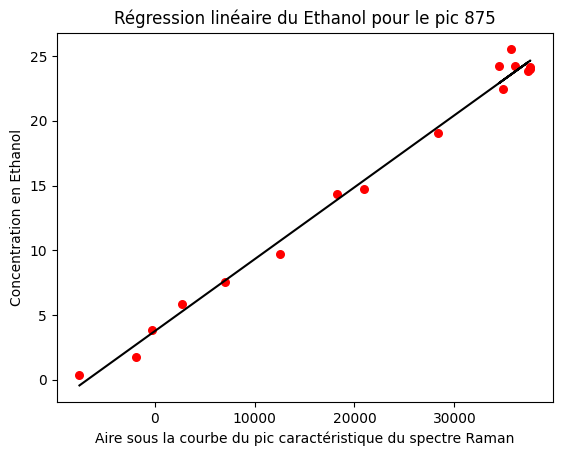

In [33]:
# Tracer la régression pour la meilleure configuration globale
plt.scatter(best_x_ethanol_global, best_y_ethanol_global, color="r", marker="o", s=30)
plt.plot(best_x_ethanol_global, best_y_pred_global, color="k")
plt.xlabel("Aire sous la courbe du pic caractéristique du spectre Raman")
plt.ylabel("Concentration en Ethanol")
plt.title(f"Régression linéaire du Ethanol pour le pic {best_pic_global}")
plt.show()